# Imports

In [1]:
import numpy as np
import itertools
from glob import glob
import torch.nn as nn
import torch
import matplotlib.pyplot as plt
from scipy.special import expit
import sys
from blazeface import FaceExtractor, BlazeFace, VideoReader
from architectures import fornet
from architectures.fornet import FeatureExtractor
from utils import utils
from utils.utils import get_transformer
from utils.utils import plot_confusion_matrix
import pandas as pd
from tqdm.notebook import tqdm
import pprint
import cv2
sys.path.append('..')

# Select architecture, device, face policy, face size, frames per video, dataset and provide model path

In [2]:
net_choices = ['TimmV2', 'TimmV2ST', 'ViT', 'ViTST']
choices = {'v2': 'TimmV2', 'v2st': 'TimmV2ST', 'vit': 'ViT', 'vitst': 'ViTST'}
device = torch.device(
    'cuda:0') if torch.cuda.is_available() else torch.device('cpu')
face_policy = 'scale'
face_size = 224
frames_per_video = 32  # -1 means entire video

dataset = "ffpp"

# Provide path to video files

In [3]:
def count_frames(path):
    video = cv2.VideoCapture(path)
    return int(video.get(cv2.CAP_PROP_FRAME_COUNT))

In [4]:
import os.path

video_paths = glob('../sample_videos/ffpp/real/**/*.mp4', recursive=True)
file_names = []
fpv = []
for i in video_paths:
    file_names.append(os.path.basename(i))
    fpv.append( count_frames(i)  )
file_names.sort()
len(file_names)
print(file_names)

video_idxs = [0,1]
print(video_idxs)

input_dir = '../sample_videos/ffpp/real/'
print(fpv)


['043.mp4', '091.mp4', '150.mp4', '250.mp4', '377.mp4', '488.mp4', '522.mp4', '666.mp4', '777.mp4', '881.mp4', '992.mp4']
[0, 1]
[495, 639, 456, 564, 398, 518, 713, 383, 325, 638, 718]


# Ensemble

In [5]:
class Ensemble(nn.Module):
    def __init__(self, models):
        super(Ensemble, self).__init__()
        self.models = nn.ModuleList(models)
        self.weightage = [1, 1, 1, 1]

    def forward(self, x):
        scores = {}
        preds = {}
        for i, model in enumerate(self.models):
            pred = model(x.to(device)).cpu().numpy().flatten()
            score = expit(pred.mean())
            scores[model.__class__.__name__] = score
            preds[model.__class__.__name__] = expit(pred)
        return scores,preds


# Get path of all models to ensemble

In [6]:
model_paths = glob('../models/**/*.pth', recursive=True)
print(model_paths)
models_for_dataset = []
for i in model_paths:
    if(i.split("/")[-1].startswith(dataset)):
        models_for_dataset.append(i)
models_for_dataset
model_paths = models_for_dataset
model_paths

['../models/celeb_vit.pth', '../models/celeb_v2.pth', '../models/celeb_v2st.pth', '../models/dfdc_v2.pth', '../models/dfdc_v2st.pth', '../models/ffpp_v2.pth', '../models/ffpp_v2st.pth', '../models/ffpp_vit.pth', '../models/ffpp_vitst.pth']


['../models/ffpp_v2.pth',
 '../models/ffpp_v2st.pth',
 '../models/ffpp_vit.pth',
 '../models/ffpp_vitst.pth']

# Load weights for all models

In [7]:
model_list = []
lim = 0
for i in tqdm(model_paths, desc="Loading Models"):
    net_name = choices[i.split("/")[2].split("_")[1].split(".")[0]]
    net_class = getattr(fornet, net_name)
    model: FeatureExtractor = net_class().eval().to(device)
    model_path = '../models/' + dataset + \
        '_' + i.split('/')[2].split('_')[1]
    model.load_state_dict(torch.load(
        model_path, map_location='cpu')['net'])
    model_list.append(model)


Loading Models:   0%|          | 0/4 [00:00<?, ?it/s]

In [8]:
len(model_list)

4

# Extract faces

In [6]:
transf = utils.get_transformer(
    face_policy, face_size, model_list[0].get_normalizer(), train=False)
facedet = BlazeFace().to(device)
facedet.load_weights("blazeface/blazeface.pth")
facedet.load_anchors("blazeface/anchors.npy")
videoreader = VideoReader(verbose=False)


def video_read_fn(x): return videoreader.read_frames(
    x, num_frames=frames_per_video)


face_extractor = FaceExtractor(video_read_fn=video_read_fn, facedet=facedet)


In [9]:
faces = face_extractor.process_videos(
    input_dir=input_dir, filenames=file_names, video_idxs=video_idxs)
total_videos = len(video_idxs)


faces_frames = [frames_per_video *
                x for x in range(0, total_videos+1)]   # [0,32,64,96]

faces_hc = torch.stack([transf(image=frame['faces'][0])['image']
                       for frame in faces if len(frame['faces'])])


Extracting faces:   0%|          | 0/2 [00:00<?, ?it/s]

# Make predictions

In [7]:
ensemble_models = Ensemble(model_list).eval().to(device)

In [11]:
predictions = {}
with torch.no_grad():
    for i in tqdm(range(0, total_videos),desc="Predicting:"):  # (0,3) i.e 0,1,2
        score,preds = ensemble_models(faces_hc[faces_frames[i]:faces_frames[i+1]])
        predictions[input_dir+file_names[video_idxs[i]]] = [score,preds, {'ensemble_score': sum(score.values())/(len(model_list))}, {
            'predicted_class': 'real' if sum(score.values())/(len(model_list)) < 0.3 else 'fake', 'true_class': input_dir.split("/")[3]}]



Predicting::   0%|          | 0/2 [00:00<?, ?it/s]

In [12]:
pprint.pprint(predictions)

{'../sample_videos/ffpp/real/043.mp4': [{'TimmV2': 0.012232197,
                                         'TimmV2ST': 0.61918104,
                                         'ViT': 0.14586504,
                                         'ViTST': 0.16916572},
                                        {'TimmV2': array([0.00872216, 0.01763926, 0.02246069, 0.01132695, 0.03835763,
       0.0131454 , 0.11518755, 0.00667132, 0.01133874, 0.01895693,
       0.00206885, 0.00480219, 0.00062077, 0.00691775, 0.00430566,
       0.00380525, 0.00092641, 0.01116817, 0.07216255, 0.09467141,
       0.00591475, 0.04562845, 0.01535223, 0.03690802, 0.0389526 ,
       0.01133066, 0.01979582, 0.06682755, 0.01950602, 0.05097976,
       0.00160344, 0.0018279 ], dtype=float32),
                                         'TimmV2ST': array([0.4990548 , 0.38916123, 0.7457302 , 0.67451847, 0.5301581 ,
       0.81691307, 0.6977466 , 0.40923777, 0.51021624, 0.8374992 ,
       0.30644032, 0.795654  , 0.27799407, 0.65075934, 0.717

# Analysis

In [72]:
pclass = []
tclass = []
res = []  # [   [predicted_class,true_class],    [predicted_class,true_class]     ....  ]
for preds in predictions:
    predicted_class = predictions[preds][-1]['predicted_class']
    true_class = predictions[preds][-1]['true_class']
    res.append([predicted_class, true_class])
    pclass.append(predicted_class)
    tclass.append(true_class)
print(pclass)
print(tclass)

['real', 'real']
['real', 'real']


In [73]:
for i in range(0, len(pclass)):
    if(pclass[i] == 'real'):
        pclass[i] = 0
    elif(pclass[i] == 'fake'):
        pclass[i] = 1

pclass = torch.Tensor(pclass)

for i in range(0, len(tclass)):
    if(tclass[i] == 'real'):
        tclass[i] = 0
    elif(tclass[i] == 'fake'):
        tclass[i] = 1
tclass = torch.Tensor(tclass)


In [74]:
stacked = torch.stack((tclass, pclass), dim=1)


In [75]:
cmt = torch.zeros(2, 2, dtype=torch.int64)
for p in stacked:
    tl, pl = p.tolist()
    cmt[int(tl), int(pl)] = cmt[int(tl), int(pl)] + 1
cmt = cmt.detach().cpu().numpy()
cmt


array([[2, 0],
       [0, 0]])

Confusion matrix, without normalization
[[2 0]
 [0 0]]


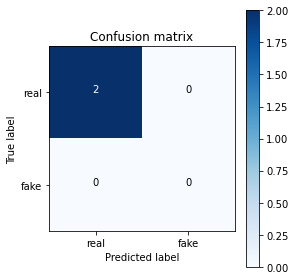

In [76]:
names = ('real', 'fake')
plt.figure(figsize=(4, 4))
plot_confusion_matrix(cmt, names)


In [77]:
data = {'video_path': [x for x in predictions.keys()],
       'prediction':  pclass   }   
df = pd.DataFrame(data)
df.to_csv('predictions.csv')

# Save video by annotating frames with frame-level score predictions

In [ ]:
video_paths = glob('../sample_videos/ffpp/real/**/*.mp4', recursive=True)

In [11]:
video_idxs = [2,5]

In [13]:
transf = utils.get_transformer(
    face_policy, face_size, model_list[0].get_normalizer(), train=False)
facedet = BlazeFace().to(device)
facedet.load_weights("blazeface/blazeface.pth")
facedet.load_anchors("blazeface/anchors.npy")
videoreader = VideoReader(verbose=False)

In [15]:
ensemble_models = Ensemble(model_list).eval().to(device)

In [16]:
# extract faces:
predictions = {}
with torch.no_grad():
    for a,i in enumerate(fpv):
        if(a in video_idxs):
            def video_read_fn(x): return videoreader.read_frames(
                x, num_frames=i)
            face_extractor = FaceExtractor(video_read_fn=video_read_fn, facedet=facedet)
            faces = face_extractor.process_video(video_paths[a])
            faces_hc = torch.stack([transf(image=frame['faces'][0])['image']
                               for frame in faces if len(frame['faces'])])
            score,preds = ensemble_models(faces_hc[0:i])
            predictions[video_paths[a]] = [score,preds,faces, {'ensemble_score': sum(score.values())/(len(model_list))}, {
                    'predicted_class': 'real' if sum(score.values())/(len(model_list)) < 0.3 else 'fake', 'true_class': input_dir.split("/")[3]}]

Extracting faces:   0%|          | 0/1 [00:00<?, ?it/s]

Extracting faces:   0%|          | 0/1 [00:00<?, ?it/s]

In [20]:
op_path = 'output/'

In [46]:
def numberWithoutRounding(num, precision=4):
    [beforeDecimal, afterDecimal] = str(num).split('.')
    return beforeDecimal + '.' + afterDecimal[0:precision]

In [ ]:
for a,i in enumerate(fpv):
    if(a in video_idxs):
        frame_count = 0
        face_count = 0
        writer = None
        success = True
        vid = cv2.VideoCapture(video_paths[a])
        while success:
            success, img = vid.read()


            if writer is None:
                fourcc = cv2.VideoWriter_fourcc(*"MJPG")
                writer = cv2.VideoWriter(op_path + os.path.basename(video_paths[a]).split(".")[0]+'.avi', fourcc, 20, (img.shape[1], img.shape[0]), True)

            faces = predictions[video_paths[a]][2]
            if(face_count==i):
                break
            if face_count < i and faces[face_count]['frame_idx'] == frame_count:
        
                if len(faces[face_count]['detections']) > 0:
                    dect = faces[face_count]['detections'][0]

                ymin, xmin, ymax, xmax = dect[0], dect[1], dect[2], dect[3]
                num_models = len(model_list)
                p = {} # contains frame level predictions for each model
                for j in preds:
                    p[j] = preds[j][face_count]
                    
                ensemble_pred_score = sum(p.values())/len(p)
                

                if ensemble_pred_score >= 0.3:
                    text = 'Fake:' + numberWithoutRounding(ensemble_pred_score, precision=4)
                    rgb = (0, 0, 255)

                else:
                    text = 'Real:' + numberWithoutRounding(ensemble_pred_score, precision=4)
                    rgb = (0, 255, 0)

                face_count += 1

            cv2.rectangle(img, (xmin, ymin), (xmax, ymax), rgb, 2)
            text_y = ymin - 15 if ymin - 15 > 15 else ymin + 15
            cv2.putText(img, text, (int(xmin), int(text_y)), cv2.FONT_HERSHEY_SIMPLEX, 0.75, rgb, 2)
            
            #cv2.putText(img, t, (10,100), cv2.FONT_HERSHEY_SIMPLEX, 0.75, rgb, 2)
            lbls = ['Model']
            for n in p:
                lbls.append(n)
            h,w,c = img.shape
            offset = 0
            for vv,ll in enumerate(lbls):
                if(ll == 'TimmV2'):
                    lbls[vv] = 'V2'
                elif(ll=='TimmV2ST'):
                    lbls[vv] = 'V2ST'
            for itr, word in enumerate(lbls):
                offset += int(h / len(lbls)) - 10
                cv2.putText(img, word, (20, offset), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 3)
                
            
            lbls_frame_pred = []
            for k in p:
                lbls_frame_pred.append(p[k])
            
            lbls_frame_pred_round = ['Score']
            for kk in lbls_frame_pred:
                lbls_frame_pred_round.append(numberWithoutRounding(kk,4))
    
            offset = 0
            for f, g in enumerate(lbls_frame_pred_round):
                if(f==0):
                    offset += int(h / len(lbls_frame_pred_round)) - 10
                    cv2.putText(img, g, (130, offset), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 3)
                    continue
                offset += int(h / len(lbls_frame_pred_round)) - 10
                if(float(g) >= 0.3):
                    cv2.putText(img, g, (130, offset), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 3)
                elif(float(g) < 0.3):
                    cv2.putText(img, g, (130, offset), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 3)
                
            writer.write(img)
            frame_count += 1

        writer.release()
